1. Model Reuse (Feature Extraction)

The initial layers of the pre-trained CNN, which have learned to extract generic features like edges, corners, and textures, are typically frozen (meaning their weights are not updated during training). This is because these low-level features are useful across a wide variety of image recognition tasks.

2. Adaptation (Fine-Tuning)

The layers that are closer to the output, which have learned task-specific features for the original dataset, are then:

Modified: The final classification layer is replaced to match the number of classes in the new dataset.

"Unfrozen" (and Retrained): A select number of the top convolutional and fully connected layers (closer to the output) are unfrozen. These layers are then trained on the new dataset using a very small learning rate. This small learning rate ensures that the model's weights are only slightly adjusted, preserving the rich, pre-learned features while tuning them to the specific nuances of the new task.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import time
import copy

# Dictionary to store results from different models
transfer_results = {}

def create_transfer_model(model_name, num_classes=10):
    """
    Create transfer learning model based on model name
    """
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False
        # Replace final layer
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        # VGG has a different classifier structure
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    
    return model

# Transform for pre-trained models (ImageNet stats)
transform_pretrained = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define data directory
data_dir = './data'

# Prepare datasets for transfer learning
trainset_transfer = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_pretrained)
testset_transfer = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_pretrained)
train_loader_transfer = DataLoader(trainset_transfer, batch_size=32, shuffle=True)  # Smaller batch for memory
val_loader_transfer = DataLoader(testset_transfer, batch_size=32, shuffle=False)

In [4]:
def train_transfer_model(model, model_name, epochs=5):
    """
    Train transfer learning model with quick evaluation
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Only train the classifier layer (faster)
    if model_name in ['resnet18']:
        optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    elif model_name in ['mobilenet_v2', 'efficientnet_b0']:
        optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    elif model_name == 'vgg16':
        optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)
    elif model_name == 'densenet121':
        optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    start_time = time.time()
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        print(f'{model_name} - Epoch {epoch+1}/{epochs}')
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader_transfer:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(trainset_transfer)
        epoch_acc = running_corrects.double() / len(trainset_transfer)
        
        # Validation phase
        model.eval()
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader_transfer:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_running_corrects.double() / len(testset_transfer)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        scheduler.step()
    
    training_time = time.time() - start_time
    print(f'{model_name} training completed in {training_time:.2f}s')
    print(f'Best Val Acc: {best_acc:.4f}')
    
    # Load best weights
    model.load_state_dict(best_model_wts)
    
    return model, float(best_acc), training_time

In [5]:
# List of models to try
models_to_try = ['resnet18', 'mobilenet_v2', 'efficientnet_b0']  # Start with lighter models

print("=== TRANSFER LEARNING COMPARISON ===")
print("Testing multiple pre-trained models on CIFAR-10\n")

for model_name in models_to_try:
    print(f"🚀 Training {model_name}...")
    try:
        # Create model
        model = create_transfer_model(model_name)
        
        # Train model
        trained_model, best_acc, training_time = train_transfer_model(model, model_name, epochs=3)  # Quick test
        
        # Store results
        transfer_results[model_name] = {
            'model': trained_model,
            'accuracy': best_acc,
            'training_time': training_time,
            'parameters': sum(p.numel() for p in trained_model.parameters())
        }
        
        print(f"✅ {model_name} completed!")
        print(f"   Accuracy: {best_acc:.4f}")
        print(f"   Training time: {training_time:.2f}s")
        print("-" * 50)
        
    except Exception as e:
        print(f"❌ Error with {model_name}: {str(e)}")
        continue

print("\n=== RESULTS SUMMARY ===")
if transfer_results:
    # Sort by accuracy
    sorted_results = sorted(transfer_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    
    print(f"{'Model':<15} {'Accuracy':<10} {'Time (s)':<10} {'Parameters':<12}")
    print("-" * 55)
    
    for model_name, results in sorted_results:
        print(f"{model_name:<15} {results['accuracy']:<10.4f} {results['training_time']:<10.2f} {results['parameters']:,}")
    
    # Best model
    best_model_name = sorted_results[0][0]
    best_model_info = sorted_results[0][1]
    
    print(f"\n🏆 WINNER: {best_model_name}")
    print(f"   Best accuracy: {best_model_info['accuracy']:.4f}")
    print(f"   Training time: {best_model_info['training_time']:.2f}s")
    
    # Save the best model
    torch.save({
        'model_name': best_model_name,
        'model_state_dict': best_model_info['model'].state_dict(),
        'accuracy': best_model_info['accuracy'],
        'training_time': best_model_info['training_time']
    }, f'best_transfer_model_{best_model_name}.pth')
    
    print(f"💾 Best model saved as 'best_transfer_model_{best_model_name}.pth'")
else:
    print("❌ No models completed successfully")

=== TRANSFER LEARNING COMPARISON ===
Testing multiple pre-trained models on CIFAR-10

🚀 Training resnet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/enriqueestevezalvarez/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/Users/enriqueestevezalvarez/Documents/Ironhack/Projects/CNN projet/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/enriqueestevezalvarez/Documents/Ironhack/Projects/CNN projet/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100.0%


resnet18 - Epoch 1/3
Train Loss: 0.8025 Acc: 0.7331
Val Acc: 0.7888
resnet18 - Epoch 2/3
Train Loss: 0.6422 Acc: 0.7793
Val Acc: 0.8031
resnet18 - Epoch 3/3
Train Loss: 0.6213 Acc: 0.7845
Val Acc: 0.7962
resnet18 training completed in 3685.54s
Best Val Acc: 0.8031
✅ resnet18 completed!
   Accuracy: 0.8031
   Training time: 3685.54s
--------------------------------------------------
🚀 Training mobilenet_v2...
mobilenet_v2 - Epoch 1/3


/Users/enriqueestevezalvarez/Documents/Ironhack/Projects/CNN projet/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Loss: 0.8763 Acc: 0.6998
Val Acc: 0.7715
mobilenet_v2 - Epoch 2/3
Train Loss: 0.7591 Acc: 0.7371
Val Acc: 0.7595
mobilenet_v2 - Epoch 3/3


/Users/enriqueestevezalvarez/Documents/Ironhack/Projects/CNN projet/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
3.7%

Train Loss: 0.7483 Acc: 0.7391
Val Acc: 0.7728
mobilenet_v2 training completed in 5284.54s
Best Val Acc: 0.7728
✅ mobilenet_v2 completed!
   Accuracy: 0.7728
   Training time: 5284.54s
--------------------------------------------------
🚀 Training efficientnet_b0...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/enriqueestevezalvarez/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100.0%


efficientnet_b0 - Epoch 1/3
Train Loss: 0.8870 Acc: 0.7136
Val Acc: 0.7933
efficientnet_b0 - Epoch 2/3
Train Loss: 0.7248 Acc: 0.7537
Val Acc: 0.7978
efficientnet_b0 - Epoch 3/3
Train Loss: 0.7075 Acc: 0.7594
Val Acc: 0.8033
efficientnet_b0 training completed in 8358.94s
Best Val Acc: 0.8033
✅ efficientnet_b0 completed!
   Accuracy: 0.8033
   Training time: 8358.94s
--------------------------------------------------

=== RESULTS SUMMARY ===
Model           Accuracy   Time (s)   Parameters  
-------------------------------------------------------
efficientnet_b0 0.8033     8358.94    4,020,358
resnet18        0.8031     3685.54    11,181,642
mobilenet_v2    0.7728     5284.54    2,236,682

🏆 WINNER: efficientnet_b0
   Best accuracy: 0.8033
   Training time: 8358.94s
💾 Best model saved as 'best_transfer_model_efficientnet_b0.pth'


=== DETAILED EVALUATION: efficientnet_b0 ===
Transfer Learning (efficientnet_b0) Results:
Accuracy: 0.8033
Precision: 0.8035
Recall: 0.8033
F1-score: 0.8027


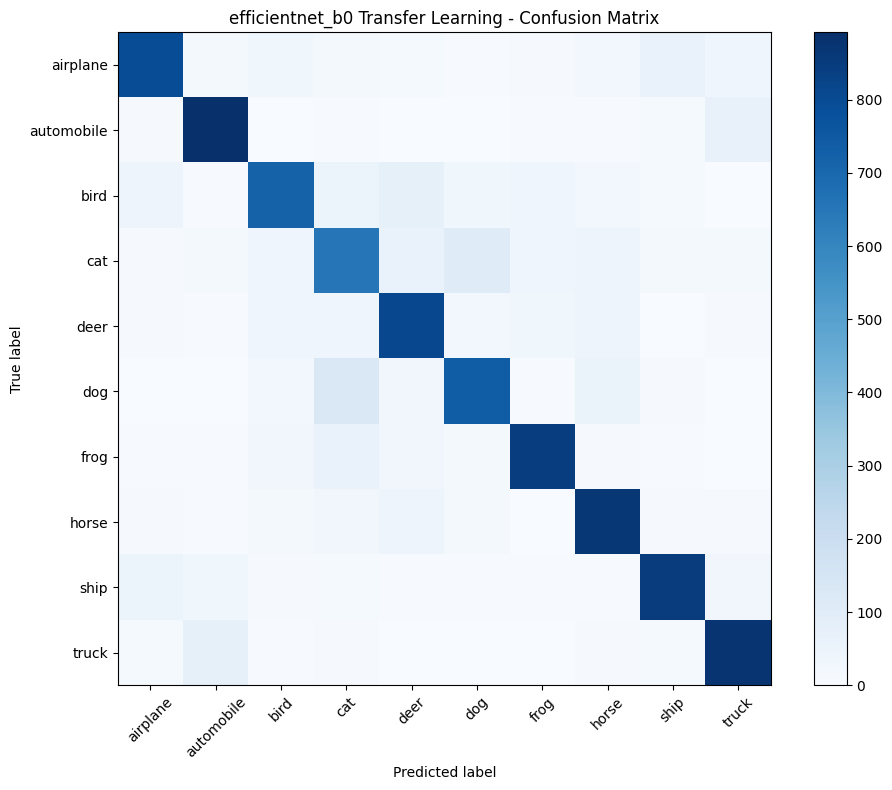


Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.85      0.79      0.82      1000
  automobile       0.84      0.89      0.87      1000
        bird       0.79      0.72      0.75      1000
         cat       0.65      0.65      0.65      1000
        deer       0.76      0.81      0.78      1000
         dog       0.78      0.74      0.76      1000
        frog       0.86      0.84      0.85      1000
       horse       0.80      0.87      0.83      1000
        ship       0.86      0.85      0.85      1000
       truck       0.84      0.88      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [7]:
import matplotlib.pyplot as plt

def evaluate_best_transfer_model():
    """
    Detailed evaluation of the best transfer learning model
    """
    if not transfer_results:
        print("No transfer learning results available!")
        return
    
    # Get the best model
    best_model_name = max(transfer_results.keys(), key=lambda k: transfer_results[k]['accuracy'])
    best_model = transfer_results[best_model_name]['model']
    
    print(f"=== DETAILED EVALUATION: {best_model_name} ===")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model = best_model.to(device)
    best_model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader_transfer:
            images = images.to(device)
            outputs = best_model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
    
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    print(f"Transfer Learning ({best_model_name}) Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{best_model_name} Transfer Learning - Confusion Matrix")
    plt.colorbar()
    
    # Add class names
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

# Run evaluation
evaluate_best_transfer_model()

In [ ]:
def plot_model_comparison():
    """
    Visualize comparison between all models (custom CNN + transfer learning)
    """
    if not transfer_results:
        print("No transfer learning results to compare!")
        return
    
    # Prepare data for plotting
    model_names = []
    accuracies = []
    training_times = []
    
    # Add custom CNN results (you'll need to get this from your previous training)
    # Assuming you have these values from your custom CNN
    custom_cnn_acc = 0.7500  # Replace with your actual accuracy
    custom_cnn_time = 300    # Replace with your actual training time
    
    model_names.append('Custom CNN')
    accuracies.append(custom_cnn_acc)
    training_times.append(custom_cnn_time)
    
    # Add transfer learning results
    for model_name, results in transfer_results.items():
        model_names.append(model_name)
        accuracies.append(results['accuracy'])
        training_times.append(results['training_time'])
    
    # Create comparison plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy comparison
    bars1 = ax1.bar(model_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars1, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')
    
    ax1.tick_params(axis='x', rotation=45)
    
    # Training time comparison
    bars2 = ax2.bar(model_names, training_times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    ax2.set_title('Training Time Comparison')
    ax2.set_ylabel('Training Time (seconds)')
    
    # Add value labels on bars
    for bar, time_val in zip(bars2, training_times):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(training_times)*0.01,
                f'{time_val:.1f}s', ha='center', va='bottom')
    
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("=== FINAL MODEL COMPARISON ===")
    best_acc_idx = accuracies.index(max(accuracies))
    fastest_idx = training_times.index(min(training_times))
    
    print(f"🏆 Best Accuracy: {model_names[best_acc_idx]} ({accuracies[best_acc_idx]:.4f})")
    print(f"⚡ Fastest Training: {model_names[fastest_idx]} ({training_times[fastest_idx]:.2f}s)")

plot_model_comparison()